In [26]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping
# Check TF version
print(tf.__version__)

# NCPS for LTC network
from ncps.tf import LTC, CfC
from ncps.wirings import AutoNCP
import seaborn as sns
import os 

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')



2.16.1


Functions to gather stock data (using realtime stock data for prediction of stock prices) and to predict stock prices using the gathered data.

In [27]:
def fetch_stock_data(symbol, start_date, end_date):
    """
    Fetches historical stock price data from Yahoo Finance.
    """
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

def preprocess_data(data):
    """
    Preprocesses the fetched stock price data.
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))
    return scaled_data, scaler

def create_dataset(data, look_back=1):
    """
    Converts an array of values into a dataset matrix.
    """
    X, Y = [], []
    for i in range(len(data) - look_back - 1):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

def split_data(data, train_size=0.8):
    """
    Splits the data into training and testing sets.
    """
    train_size = int(len(data) * train_size)
    train_data, test_data = data[:train_size], data[train_size:]
    return train_data, test_data


Basic EDA

In [28]:
def perform_eda(data):
    """
    Performs basic exploratory data analysis on the given dataframe.
    Displays a grid of EDA plots.
    """
    # Summary statistics
    summary = data.describe()
    
    # Correlation matrix
    corr_matrix = data.corr()
    
    # Distribution plots
    dist_plots = []
    for column in data.columns:
        dist_plots.append(sns.histplot(data[column], kde=True))
    
    # Box plots
    box_plots = []
    for column in data.columns:
        box_plots.append(sns.boxplot(data[column]))
    
    # Create grid layout
    grid = plt.GridSpec(2, 2)
    
    # Plot summary statistics
    plt.subplot(grid[0, 0])
    sns.heatmap(summary, annot=True, cmap='Blues', cbar=False, linewidths=0.5)
    plt.title('Summary Statistics')
    
    # Plot correlation matrix
    plt.subplot(grid[0, 1])
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', cbar=False, linewidths=0.5)
    plt.title('Correlation Matrix')
    
    # Plot distribution plots
    plt.subplot(grid[1, 0])
    for plot in dist_plots:
        plot.set_xlabel('')
    plt.title('Distribution Plots')
    
    # Plot box plots
    plt.subplot(grid[1, 1])
    for plot in box_plots:
        plot.set_xlabel('')
    plt.title('Box Plots')
    
    # Adjust layout and display the grid
    plt.tight_layout(pad=3.0)
    plt.show()

LSTM Architecture

In [29]:
def build_lstm_model(look_back, units=50):
    model = Sequential()
    model.add(InputLayer(input_shape=(look_back, 1)))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=units))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model
    


LTC Architecture (using NCPS)

In [30]:
def build_ltc_model(look_back, units=50):
    wiring = AutoNCP(units=units,output_size=1)
    model = Sequential([
        InputLayer(input_shape=(look_back, 1)),
        LTC(units=wiring, return_sequences=True),
        LTC(units=wiring),
        Dense(units=1)
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.015) # Higher LR required for LTC
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    model.summary()
    return model



Combined LTC and LSTM Architecture

In [31]:
def build_lstm_ltc(look_back, units=50):
    wiring = AutoNCP(units=units,output_size=1)
    model = Sequential()
    model.add(InputLayer(input_shape=(look_back, 1)))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LTC(units=wiring))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model

def build_ltc_lstm(look_back, units=50):
    wiring = AutoNCP(units=units,output_size=1)
    model = Sequential()
    model.add(InputLayer(input_shape=(look_back, 1)))
    model.add(LTC(units=wiring, return_sequences=True))
    model.add(LSTM(units=units))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model

Basic Training and Evaluation

In [32]:
def train_and_evaluate(model, X_train, Y_train, X_test, Y_test, epochs=100, batch_size=32):
    # early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    # history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stopping], verbose=1)
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1)
    predictions = model.predict(X_test)
    return predictions, history


Performance Metrics

In [33]:
def calculate_metrics(Y_true, Y_pred):
    accuracy = accuracy_score(np.sign(Y_true), np.sign(Y_pred))
    f1 = f1_score(np.sign(Y_true), np.sign(Y_pred), average='weighted')
    return accuracy, f1


In [34]:
def plot_predictions(Y_true, Y_pred_lstm, Y_pred_ltc, combined=False, save_path=None):
    plt.figure(figsize=(12, 6))
    plt.plot(Y_true, label='Actual')
    label1 = 'LSTM Predictions' if not combined else 'LSTM-First Predictions'
    label2 = 'LTC Predictions' if not combined else 'LTC-First Predictions'
    plt.plot(Y_pred_lstm, label=label1)
    plt.plot(Y_pred_ltc, label=label2)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.title('Stock Price Prediction')
    plt.show()
    if save_path:
        plt.savefig(save_path)



[*********************100%%**********************]  1 of 1 completed


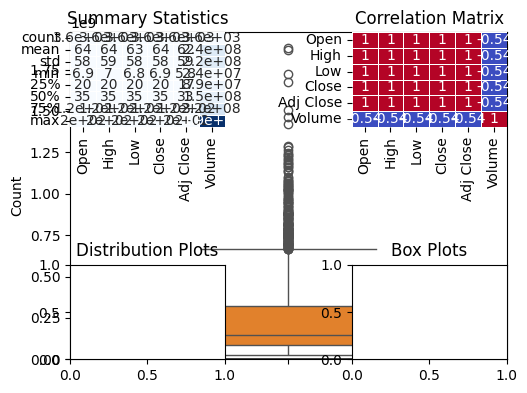

In [35]:
# Example stock given, any ticker in Yahoo! Finance can be used
symbol = 'AAPL'
start_date = '2010-01-01'
end_date = '2024-06-10'

# Fetch data
data = fetch_stock_data(symbol, start_date, end_date)

# Perform EDA
perform_eda(data)

# Preprocess data
scaled_data, scaler = preprocess_data(data)

# Split data into train and test sets
look_back = 30  # Adjust as needed
X, Y = create_dataset(scaled_data, look_back)
X_train, X_test = split_data(X)
Y_train, Y_test = split_data(Y)

# Reshape data for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [36]:
# # Build and train LSTM model
lstm_model = build_lstm_model(look_back)
predictions_lstm, history_lstm = train_and_evaluate(lstm_model, X_train, Y_train, X_test, Y_test)

# Build and train LTC model
ltc_model = build_ltc_model(look_back)
predictions_ltc, history_ltc = train_and_evaluate(ltc_model, X_train, Y_train, X_test, Y_test)

# Build and train combined LSTM/LTC model (LSTM -> LTC)
lstm_ltc_model = build_lstm_ltc(look_back)
predictions_lstm_ltc, history_lstm_ltc = train_and_evaluate(lstm_ltc_model, X_train, Y_train, X_test, Y_test)

# Build and train combined LSTM-LTC model (LTC -> LSTM)
ltc_lstm_model = build_ltc_lstm(look_back)
predictions_ltc_lstm, history_ltc_lstm = train_and_evaluate(ltc_lstm_model, X_train, Y_train, X_test, Y_test)


c:\Users\atulp\Documents\VSC\Django-Ticker-Prediction\macro-cycle\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0034 - val_loss: 6.5970e-04
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4011e-05 - val_loss: 6.4699e-04
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 5.3421e-05 - val_loss: 5.7898e-04
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.2403e-05 - val_loss: 5.9501e-04
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.9743e-05 - val_loss: 8.6500e-04
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.1692e-05 - val_loss: 6.6480e-04
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0135e-05 - val_loss: 0.0010
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0976e-05 - val_loss: 7.4641e-04
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.6385e-05 - val_loss: 0.0011
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4796e-05 - val_loss: 6.5490e-04
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.5053e-05

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ltc_4 (LTC)                     │ (None, 30, 1)          │        10,354 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ltc_5 (LTC)                     │ (None, 1)              │        10,354 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,710 (80.90 KB)

 Trainable params: 20,710 (80.90 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 30s 271ms/step - loss: 0.0056 - val_loss: 0.1457
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step - loss: 0.0040 - val_loss: 0.1543
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 253ms/step - loss: 0.0041 - val_loss: 0.1624
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 254ms/step - loss: 0.0041 - val_loss: 0.1487
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - loss: 0.0038 - val_loss: 0.1510
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 279ms/step - loss: 0.0040 - val_loss: 0.1420
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - loss: 0.0040 - val_loss: 0.1526
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 268ms/step - loss: 0.0039 - val_loss: 0.1494
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 264ms/step - loss: 0.0038 - val_loss: 0.1490
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 275ms/step - loss: 0.0038 - val_loss: 0.1380
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 19s 265ms/step - loss: 0.0039 - val_loss: 0.1498
Epoch 12/100
72/72 ━━━━━━━━━━━

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ltc_6 (LTC)                     │ (None, 1)              │        20,252 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,654 (119.74 KB)

 Trainable params: 30,654 (119.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - loss: 0.3830 - val_loss: 0.0715
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 0.0014 - val_loss: 0.0392
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 5.9891e-04 - val_loss: 0.0329
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 3.9560e-04 - val_loss: 0.0360
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - loss: 3.1883e-04 - val_loss: 0.0359
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - loss: 2.4660e-04 - val_loss: 0.0373
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 2.3190e-04 - val_loss: 0.0357
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 2.0568e-04 - val_loss: 0.0364
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 1.9109e-04 - val_loss: 0.0372
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - loss: 1.8616e-04 - val_loss: 0.0380
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 138ms/step - loss: 1.6117e-04 - val_loss: 0

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ltc_7 (LTC)                     │ (None, 30, 1)          │        10,354 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,805 (81.27 KB)

 Trainable params: 20,805 (81.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 144ms/step - loss: 0.0048 - val_loss: 0.0730
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - loss: 3.7218e-04 - val_loss: 0.0329
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - loss: 6.2125e-05 - val_loss: 0.0330
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 5.0831e-05 - val_loss: 0.0327
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - loss: 4.5586e-05 - val_loss: 0.0307
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 4.0843e-05 - val_loss: 0.0318
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 4.0460e-05 - val_loss: 0.0324
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 3.7339e-05 - val_loss: 0.0322
Epoch 9/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - loss: 2.8737e-05 - val_loss: 0.0314
Epoch 10/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 2.7860e-05 - val_loss: 0.0311
Epoch 11/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 2.6703e-05 - val_loss: 0.029

LSTM Model - Accuracy: 1.0, F1 Score: 1.0
LTC Model - Accuracy: 1.0, F1 Score: 1.0
LSTM -> LTC Model - Accuracy: 1.0, F1 Score: 1.0
LTC -> LSTM Model - Accuracy: 1.0, F1 Score: 1.0


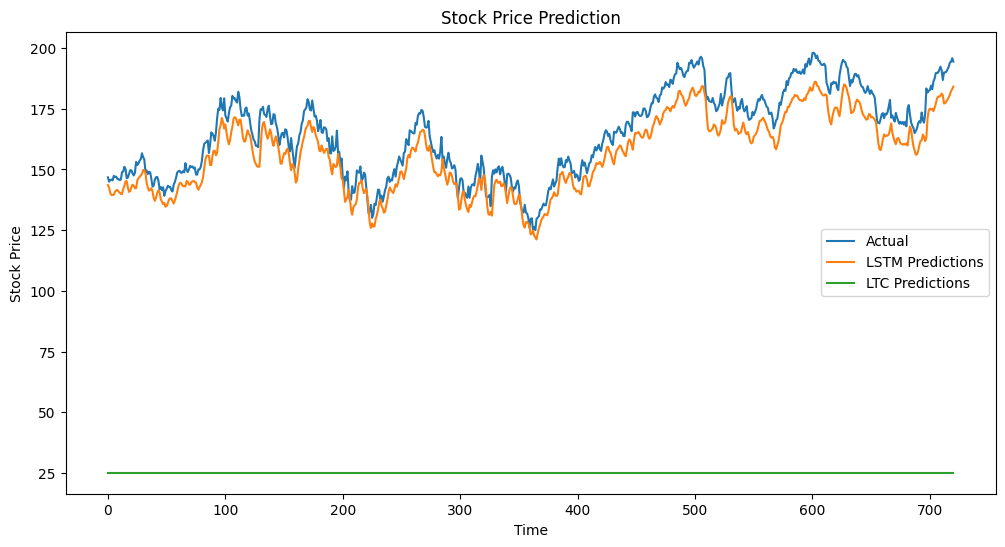

<Figure size 640x480 with 0 Axes>

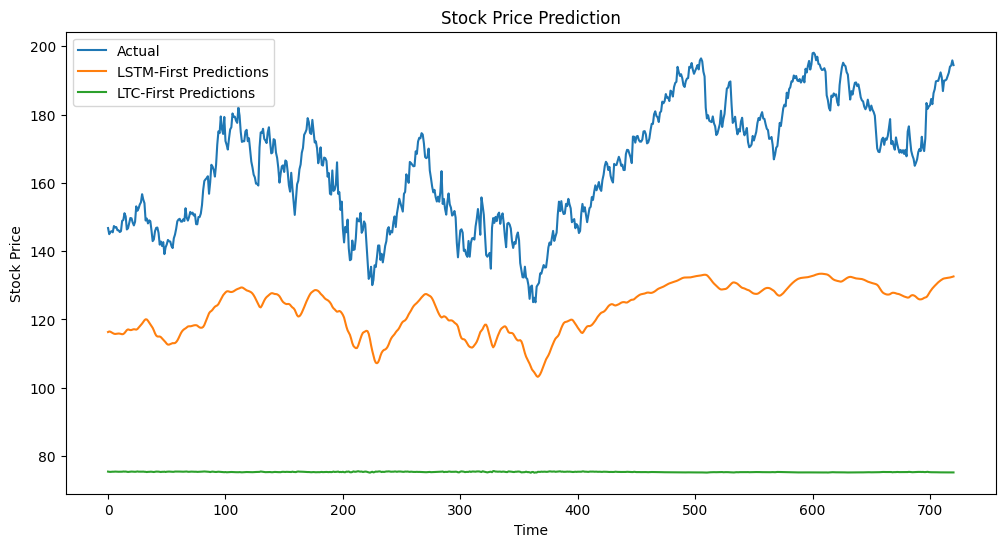

ValueError: All arrays must be of the same length

<Figure size 640x480 with 0 Axes>

In [37]:
# Inverse transform predictions
import datetime

pred_directory = os.path.join(os.pardir, 'testing_metrics')
save_time = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

predictions_lstm = scaler.inverse_transform(predictions_lstm)
predictions_ltc = scaler.inverse_transform(predictions_ltc)
predictions_lstm_ltc = scaler.inverse_transform(predictions_lstm_ltc)
predictions_ltc_lstm = scaler.inverse_transform(predictions_ltc_lstm)
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

# Calculate and print metrics
accuracy_lstm, f1_lstm = calculate_metrics(Y_test_actual, predictions_lstm)
accuracy_ltc, f1_ltc = calculate_metrics(Y_test_actual, predictions_ltc)
accuracy_lstm_ltc, f1_lstm_ltc = calculate_metrics(Y_test_actual, predictions_lstm_ltc)
accuracy_ltc_lstm, f1_ltc_lstm = calculate_metrics(Y_test_actual, predictions_ltc_lstm)
print(f"LSTM Model - Accuracy: {accuracy_lstm}, F1 Score: {f1_lstm}")
print(f"LTC Model - Accuracy: {accuracy_ltc}, F1 Score: {f1_ltc}")
print(f"LSTM -> LTC Model - Accuracy: {accuracy_lstm_ltc}, F1 Score: {f1_lstm_ltc}")
print(f"LTC -> LSTM Model - Accuracy: {accuracy_ltc_lstm}, F1 Score: {f1_ltc_lstm}")

# Plot and save LSTM vs LTC predictions
plot_predictions(Y_test_actual, predictions_lstm, predictions_ltc, save_path=os.path.join(pred_directory, f'predictions_{save_time}.png'))

# Do the same for the combined predictions
plot_predictions(Y_test_actual, predictions_lstm_ltc, predictions_ltc_lstm, combined=True, save_path=os.path.join(pred_directory, f'predictions_combined_{save_time}.png'))

# Save predictions metrics to a CSV file
predictions = pd.DataFrame({
    'Actual': Y_test_actual.flatten(),
    'LSTM Predictions': predictions_lstm.flatten(),
    'LTC Predictions': predictions_ltc.flatten(),
    'LSTM -> LTC Predictions': predictions_lstm_ltc.flatten(),
    'LTC -> LSTM Predictions': predictions_ltc_lstm.flatten(),
    'F1 Score': [f1_lstm, f1_ltc, f1_lstm_ltc, f1_ltc_lstm],
    'Accuracy': [accuracy_lstm, accuracy_ltc, accuracy_lstm_ltc, accuracy_ltc_lstm]
})

# Save predictions metrics themselves to CSV
predictions.to_csv(os.path.join(pred_directory, f'predictions_{save_time}.csv'), index=False)